In [1]:
!pip install --upgrade scikit-learn imbalanced-learn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 85.9 MB/s eta 0:00:00:00:0100:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
category-encoders 2.7.0 requires scikit-learn<1.6.0,>=1.0.0, but you have scikit-learn 1.6.1 which is incompatible.
bigframes 1.36.0 requires rich<14,>=12.4.4, but you have rich 14.0.0 which is incompatible.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.cluster import DBSCAN
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score

2025-04-22 14:57:59.660676: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745333879.882525      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745333879.951262      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
df = pd.read_csv("/kaggle/input/fraud-detection/fraudTrain.csv")
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long              

In [5]:
df1 = pd.read_csv("/kaggle/input/fraud-detection/fraudTest.csv")

In [6]:
def preprocess(df):
    df = df.drop(columns=['Unnamed: 0', 'first', 'last', 'street', 'zip', 'trans_num','unix_time','cc_num'])
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    df['dob'] = pd.to_datetime(df['dob'])
    # Age
    df['age'] = df['trans_date_trans_time'].dt.year - df['dob'].dt.year
    df = df.drop(columns=['dob','trans_date_trans_time'])
    #handle outliers using IQR
    num_col = df.select_dtypes(include=['float64','int64']).columns
    for col in num_col:
        if col in ['amt', 'city_pop']:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3-Q1
            lower_limit = Q1 - 1.5*IQR
            upper_limit = Q3 + 1.5*IQR
            df[col] = df[col].clip(lower=lower_limit, upper=upper_limit)
    df['gender'] = df['gender'].apply(lambda x: 1 if x=='M' else 0)
    # Encode categorical columns
    label_encoder = LabelEncoder()
    cate_col = df.select_dtypes(include=['object', 'category']).columns
    for col in cate_col:
        df[col] = label_encoder.fit_transform(df[col])

    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
    
    return df_scaled

In [7]:
df_preprocessed = preprocess(df)
df1_preprocessed = preprocess(df1)

df_preprocessed

,merchant,category,amt,gender,city,state,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,age
0,0.742775,0.615385,0.020637,0.0,0.589026,0.54,0.343968,0.864638,0.069884,0.750507,0.350302,0.848602,0.0,0.207317
1,0.348266,0.307692,0.552203,0.0,0.685330,0.94,0.618450,0.485682,0.002536,0.868154,0.621488,0.486208,0.0,0.329268
2,0.563584,0.000000,1.000000,1.0,0.524076,0.26,0.474727,0.546553,0.083148,0.622718,0.497559,0.546697,0.0,0.524390
3,0.520231,0.153846,0.228720,1.0,0.094065,0.52,0.561509,0.548070,0.038565,0.665314,0.577663,0.542619,0.0,0.463415
4,0.429191,0.692308,0.212917,1.0,0.241881,0.90,0.394153,0.882190,0.001530,0.235294,0.405244,0.882857,0.0,0.231707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1296670,0.721098,0.000000,0.075686,1.0,0.369541,0.88,0.379084,0.544346,0.004730,0.436105,0.367421,0.551347,0.0,0.548780
1296671,0.002890,0.076923,0.263548,1.0,0.910414,0.40,0.412281,0.902174,0.001550,0.730223,0.410026,0.886727,0.0,0.329268
1296672,0.865607,0.076923,0.545445,1.0,0.387458,0.64,0.276699,0.612486,0.017632,0.624746,0.300969,0.617133,0.0,0.475610
1296673,0.735549,0.076923,0.384146,1.0,0.527436,0.82,0.499837,0.646029,0.022201,0.983773,0.490098,0.636080,0.0,0.317073


In [8]:
df_preprocessed.describe()

,merchant,category,amt,gender,city,state,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,age
count,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06
mean,4.954603e-01,4.790606e-01,2.956181e-01,4.525513e-01,4.986151e-01,5.335456e-01,3.966580e-01,7.720469e-01,2.725721e-01,5.094796e-01,4.024042e-01,7.665916e-01,5.788652e-03,3.906012e-01
std,2.903929e-01,3.010341e-01,2.762236e-01,4.977437e-01,2.895858e-01,2.866196e-01,1.087684e-01,1.407982e-01,3.856712e-01,2.841975e-01,1.053945e-01,1.380971e-01,7.586269e-02,2.119802e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.384393e-01,2.307692e-01,4.496426e-02,0.000000e+00,2.508399e-01,3.000000e-01,3.127188e-01,7.047983e-01,1.449202e-02,2.657201e-01,3.239477e-01,6.996964e-01,0.000000e+00,2.317073e-01
50%,5.000000e-01,4.615385e-01,2.418194e-01,0.000000e+00,4.916013e-01,5.600000e-01,4.141584e-01,8.001821e-01,4.897097e-02,5.091278e-01,4.194896e-01,7.945505e-01,0.000000e+00,3.658537e-01
75%,7.427746e-01,7.692308e-01,4.269786e-01,1.000000e+00,7.581187e-01,7.600000e-01,4.695754e-01,8.750773e-01,4.086952e-01,7.586207e-01,4.729415e-01,8.667685e-01,0.000000e+00,5.243902e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


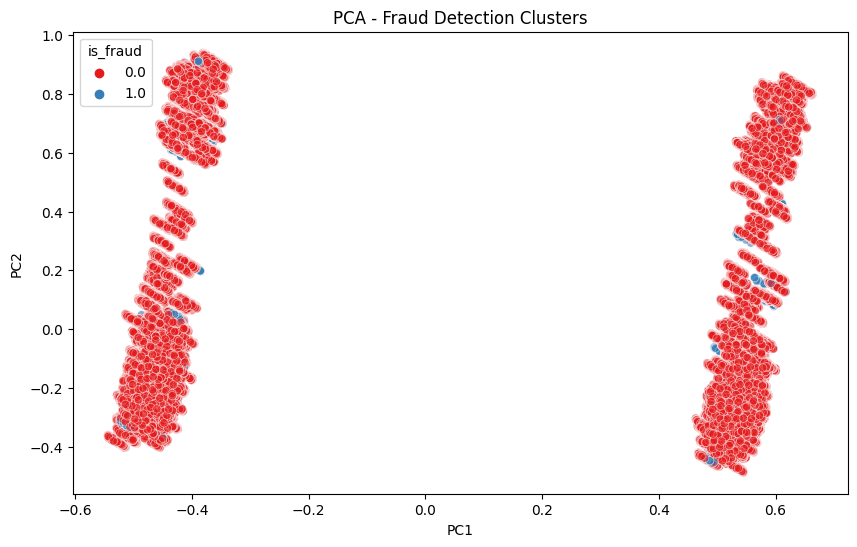

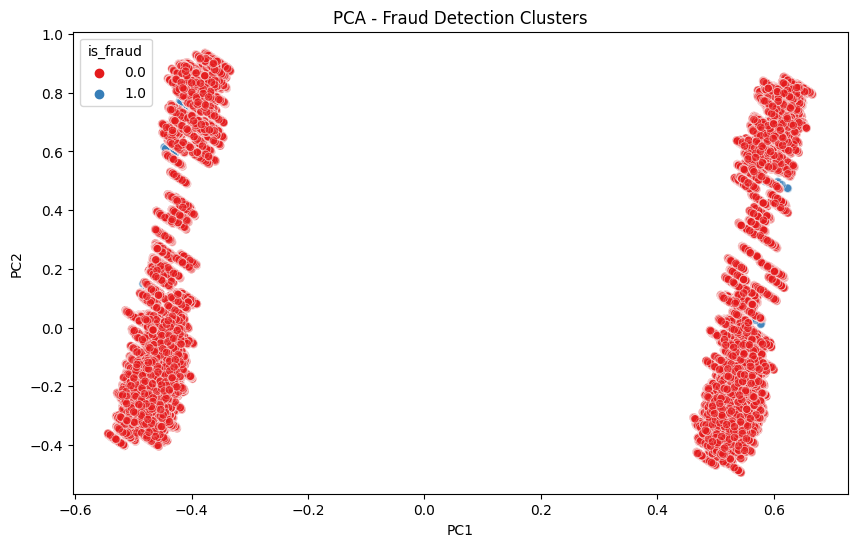

In [9]:
from sklearn.decomposition import PCA

def pca_viz(df):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(df.drop(columns=['is_fraud']))
    df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
    df_pca['is_fraud'] = df['is_fraud'].values

    plt.figure(figsize=(10,6))
    sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='is_fraud', palette='Set1', alpha=0.6)
    plt.title('PCA - Fraud Detection Clusters')
    plt.show()
pca_viz(df_preprocessed)
pca_viz(df1_preprocessed)

In [10]:
x_train = df_preprocessed.drop(columns=['is_fraud'])
y_train = df_preprocessed['is_fraud']

x_test = df1_preprocessed.drop(columns=['is_fraud'])
y_test = df1_preprocessed['is_fraud']

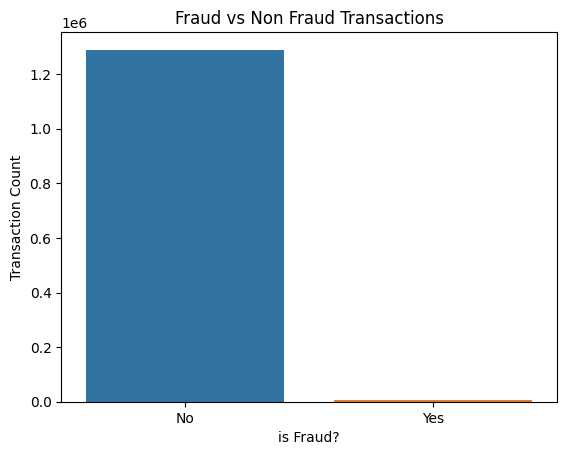

In [11]:
sns.countplot(x='is_fraud', data=df_preprocessed)
plt.title("Fraud vs Non Fraud Transactions")
plt.xlabel('is Fraud?')
plt.ylabel('Transaction Count')
plt.xticks([0,1],['No','Yes'])
plt.show()

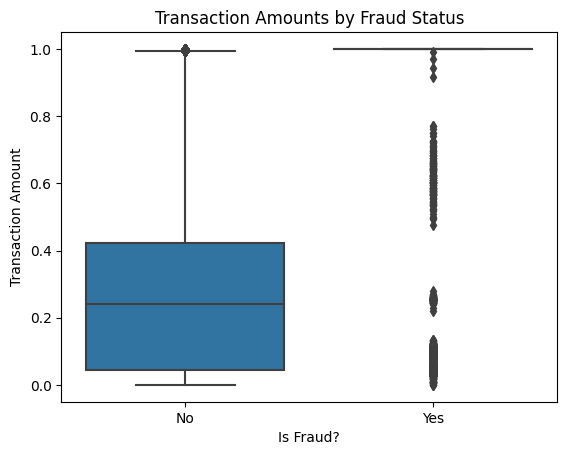

In [12]:
sns.boxplot(x='is_fraud', y='amt', data=df_preprocessed)
plt.title('Transaction Amounts by Fraud Status')
plt.xlabel('Is Fraud?')
plt.ylabel('Transaction Amount')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

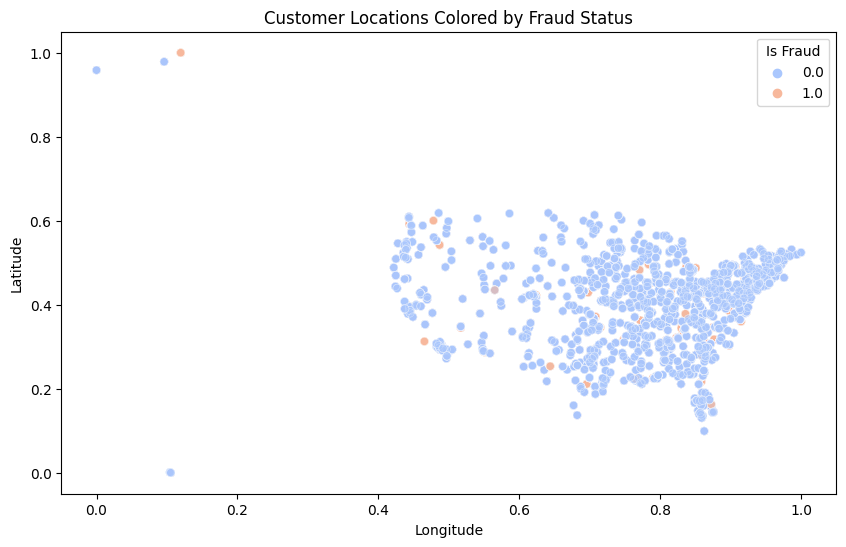

In [13]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='long', y='lat', hue='is_fraud', data=df_preprocessed, alpha=0.4, palette='coolwarm')
plt.title('Customer Locations Colored by Fraud Status')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(title='Is Fraud')
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

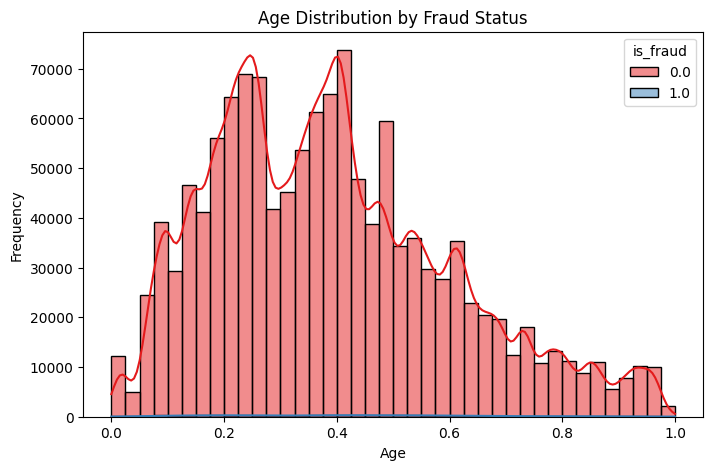

In [14]:
plt.figure(figsize=(8, 5))
sns.histplot(data=df_preprocessed, x='age', hue='is_fraud', kde=True, bins=40, palette='Set1')
plt.title('Age Distribution by Fraud Status')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

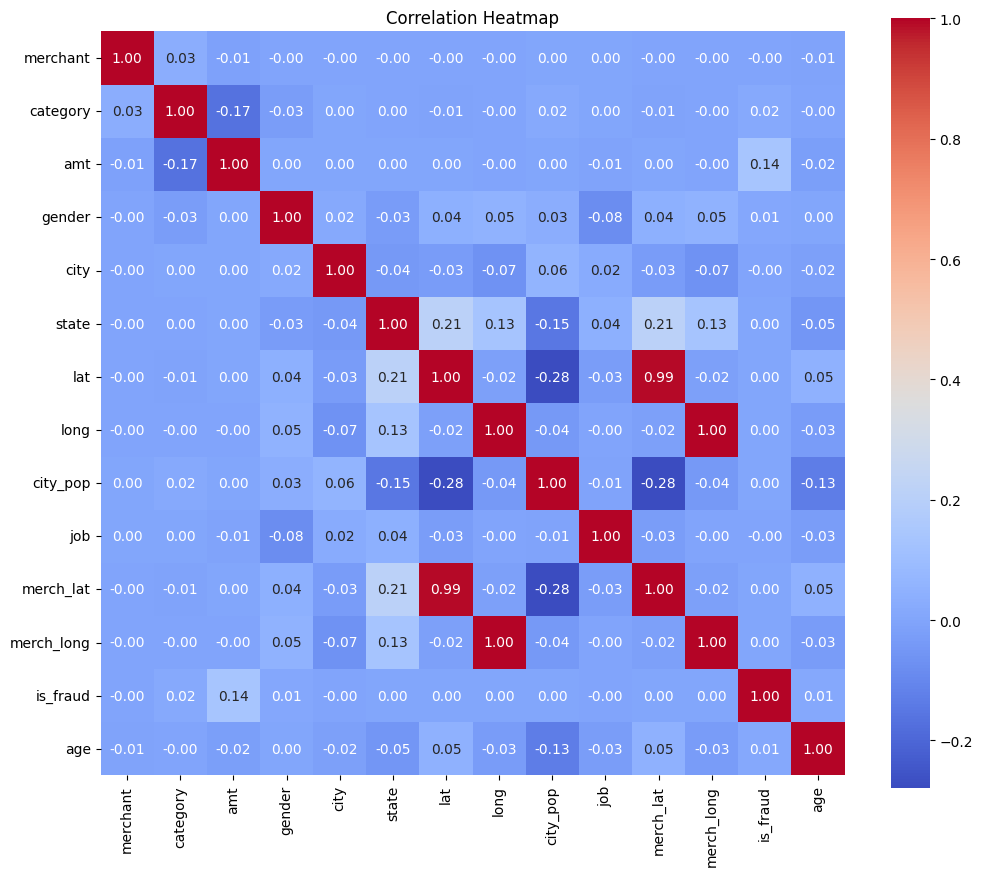

In [15]:
# correlation Heatmap
plt.figure(figsize=(12,10))
corr = df_preprocessed.corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

In [16]:
from imblearn.over_sampling import SMOTE
from collections import Counter

print("Class Distribution before SMOTE:", Counter(y_train))

smote = SMOTE(sampling_strategy='auto', random_state=42)
x_train_bal, y_train_bal = smote.fit_resample(x_train, y_train)
print("class Distribution after SMOTE:", Counter(y_train_bal))

Class Distribution before SMOTE: Counter({0.0: 1289169, 1.0: 7506})
class Distribution after SMOTE: Counter({0.0: 1289169, 1.0: 1289169})


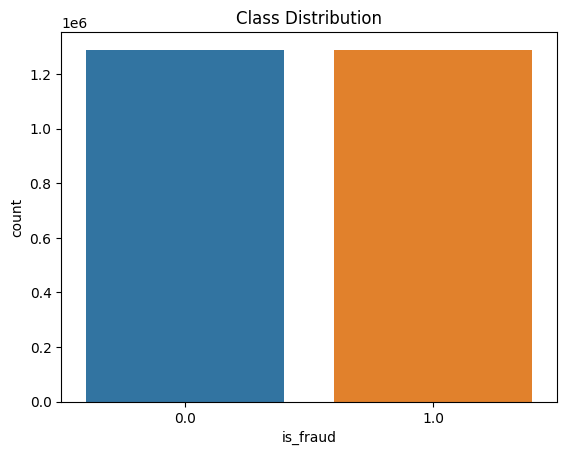

In [18]:
sns.countplot(x=y_train_bal)
plt.title('Class Distribution')
plt.show()

Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(class_weight='balanced',random_state=42)
model.fit(x_train,y_train)

y_pred = model.predict(x_test)

In [24]:
print(f'Confusion Matrix:\n {confusion_matrix(y_test, y_pred)}')
print(f'Classification report:\n {classification_report(y_test, y_pred, digits=4)}')
print(f'Accuracy: \n{accuracy_score(y_test, y_pred)}')

Confusion Matrix:
 [[465501  88073]
 [   503   1642]]
Classification report:
               precision    recall  f1-score   support

         0.0     0.9989    0.8409    0.9131    553574
         1.0     0.0183    0.7655    0.0358      2145

    accuracy                         0.8406    555719
   macro avg     0.5086    0.8032    0.4744    555719
weighted avg     0.9951    0.8406    0.9097    555719

Accuracy: 
0.8406100925107833


In [29]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [30]:
print(f'Confusion Matrix:\n {confusion_matrix(y_test, y_pred)}')
print(f'Classification report:\n {classification_report(y_test, y_pred, digits=4)}')
print(f'Accuracy: \n{accuracy_score(y_test, y_pred)}')

Confusion Matrix:
 [[553447    127]
 [  1645    500]]
Classification report:
               precision    recall  f1-score   support

         0.0     0.9970    0.9998    0.9984    553574
         1.0     0.7974    0.2331    0.3608      2145

    accuracy                         0.9968    555719
   macro avg     0.8972    0.6164    0.6796    555719
weighted avg     0.9963    0.9968    0.9959    555719

Accuracy: 
0.9968113381043298


In [31]:
import joblib

# Save the model
joblib.dump(model, 'random_forest_fraud.pkl')

['random_forest_fraud.pkl']

In [27]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(contamination=0.01, random_state=42)
model.fit(x_train,y_train)
y_pred = model.predict(x_test)

In [28]:
print(f'accuracy: {accuracy_score(y_test,y_pred)}')

accuracy: 0.0036637221329484868
